In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install scikit-learn


In [3]:
import pandas as pd
train=pd.read_csv('/content/drive/MyDrive/BBB dataset/bbb_cns_train.csv')
val=pd.read_csv('/content/drive/MyDrive/BBB dataset/bbb_cns_val.csv')
test=pd.read_csv('/content/drive/MyDrive/BBB dataset/bbb_cns_test.csv')
total=pd.read_csv('/content/drive/MyDrive/BBB dataset/total.csv')

In [4]:
total

,smiles_standarized,label,group
0,O=NN(CCCl)C(=O)NC1CCC(=O)NC1=O,-2.8,training
1,CCCN(CCC)S(=O)(=O)c1ccc(C(=O)O)cc1,-3.9,training
2,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,-3.5,training
3,CN=C(NC#N)NCCSCc1[nH]cnc1C,-4.1,training
4,O=c1[nH]cnc2c1ncn2[C@H]1CC[C@@H](CO)O1,-4.5,training
...,...,...,...
148,Cn1c(=O)c2[nH]cnc2n(C)c1=O,-2.9,val
149,Cc1cc(=O)n(-c2ccccc2)n1C,-2.0,val
150,Cn1cc(O)nc1N,-4.6,val
151,O=c1[nH]c(=O)c2[nH]cnc2[nH]1,-3.8,val


In [5]:
!pip install rdkit-pypi
!pip install pandas
!pip install Pillow
!pip install matplotlib
!pip install pydot
!sudo apt-get -qq install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 21.8 MB/s eta 0:00:00


In [6]:
import os

# Temporary suppress tf logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage

# Temporary suppress warnings and RDKit logs
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

np.random.seed(42)
tf.random.set_seed(42)

In [7]:
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)


In [8]:

def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loops
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )


# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(total.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(total.shape[0] * 0.8)]
x_train = graphs_from_smiles(total.iloc[train_index].smiles_standarized)
y_train = total.iloc[train_index].label

# Valid set: 19 % of data
valid_index = permuted_indices[int(total.shape[0] * 0.8) : int(total.shape[0] * 0.99)]
x_valid = graphs_from_smiles(total.iloc[valid_index].smiles_standarized)
y_valid = total.iloc[valid_index].label

# Test set: 1 % of data
test_index = permuted_indices[int(total.shape[0] * 0.99) :]
x_test = graphs_from_smiles(total.iloc[test_index].smiles_standarized)
y_test = total.iloc[test_index].label


SMILES:	Clc1ccc2c(c1)C(N1CCNCC1)=Nc1ccccc1O2
Label:	-1.2
Molecule:


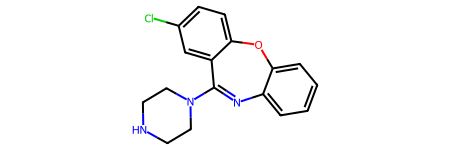

In [9]:
print(f"SMILES:\t{train.smiles_standarized[100]}\nLabel:\t{train.label[100]}")
molecule = molecule_from_smiles(train.iloc[100].smiles_standarized)
print("Molecule:")
molecule

In [10]:
graph = graph_from_molecule(molecule)
print("Graph (including self-loops):")
print("\tatom features\t", graph[0].shape)
print("\tbond features\t", graph[1].shape)
print("\tpair indices\t", graph[2].shape)

Graph (including self-loops):
	atom features	 (22, 29)
	bond features	 (72, 7)
	pair indices	 (72, 2)


In [11]:
def prepare_batch(x_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)

In [12]:
class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Obtain atom features of neighbors
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # Apply neighborhood aggregation
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim.
        # Alternatively, a dense layer could be used here.
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Update node state via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated


In [13]:
class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):

        atom_features, molecule_indicator = inputs

        # Obtain subgraphs
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        # Remove empty subgraphs (usually for last batch in dataset)
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)


class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32, **kwargs
    ):
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)

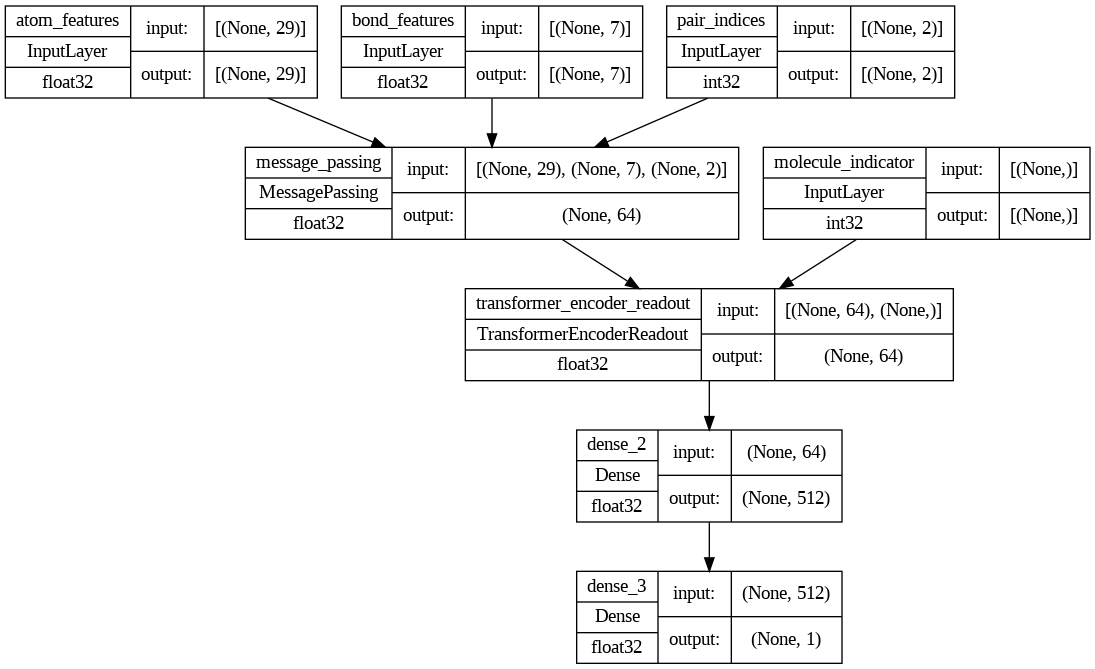

In [14]:
def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size=32,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512,
):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])

    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dense(1, activation=None)(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],
    )
    return model


mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

mpnn.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.MeanAbsoluteError(name="MAE")],
)

keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# TEST 1:

In [16]:
# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(total.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(total.shape[0] * 0.8)]
x_train = graphs_from_smiles(total.iloc[train_index].smiles_standarized)
y_train = total.iloc[train_index].label

# Valid set: 20 % of data
valid_index = permuted_indices[int(total.shape[0] * 0.8) : ]
x_valid = graphs_from_smiles(total.iloc[valid_index].smiles_standarized)
y_valid = total.iloc[valid_index].label


In [17]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    verbose=2,
    callbacks=[early_stopping]
)


Epoch 1/40
4/4 - 9s - loss: 3.0679 - MAE: 1.3600 - val_loss: 1.4015 - val_MAE: 1.0461 - 9s/epoch - 2s/step
Epoch 2/40
4/4 - 2s - loss: 1.3475 - MAE: 0.9784 - val_loss: 0.9456 - val_MAE: 0.7753 - 2s/epoch - 612ms/step
Epoch 3/40
4/4 - 2s - loss: 1.2843 - MAE: 0.9471 - val_loss: 1.0565 - val_MAE: 0.9057 - 2s/epoch - 565ms/step
Epoch 4/40
4/4 - 2s - loss: 1.2008 - MAE: 0.9323 - val_loss: 0.8759 - val_MAE: 0.7598 - 2s/epoch - 403ms/step
Epoch 5/40
4/4 - 2s - loss: 1.1293 - MAE: 0.8826 - val_loss: 0.9060 - val_MAE: 0.7722 - 2s/epoch - 394ms/step
Epoch 6/40
4/4 - 2s - loss: 1.0622 - MAE: 0.8700 - val_loss: 0.8424 - val_MAE: 0.6947 - 2s/epoch - 412ms/step
Epoch 7/40
4/4 - 2s - loss: 0.9591 - MAE: 0.7986 - val_loss: 0.8467 - val_MAE: 0.7244 - 2s/epoch - 414ms/step
Epoch 8/40
4/4 - 2s - loss: 0.9122 - MAE: 0.7629 - val_loss: 0.6967 - val_MAE: 0.6350 - 2s/epoch - 468ms/step
Epoch 9/40
4/4 - 3s - loss: 0.8824 - MAE: 0.7614 - val_loss: 0.6346 - val_MAE: 0.6249 - 3s/epoch - 643ms/step
Epoch 10/40
4

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

train_predictions = mpnn.predict(train_dataset)
train_loss, train_mae = mpnn.evaluate(train_dataset)
print(f"Train MAE: {train_mae}")

r2_train = r2_score(y_train, train_predictions)
print(f"Training R-squared: {r2_train}")



4/4 [==============================] - 1s 128ms/step - loss: 0.8528 - MAE: 0.7203
Train MAE: 0.7203178405761719
Training R-squared: 0.359920706741121


1/1 [==============================] - 0s 194ms/step


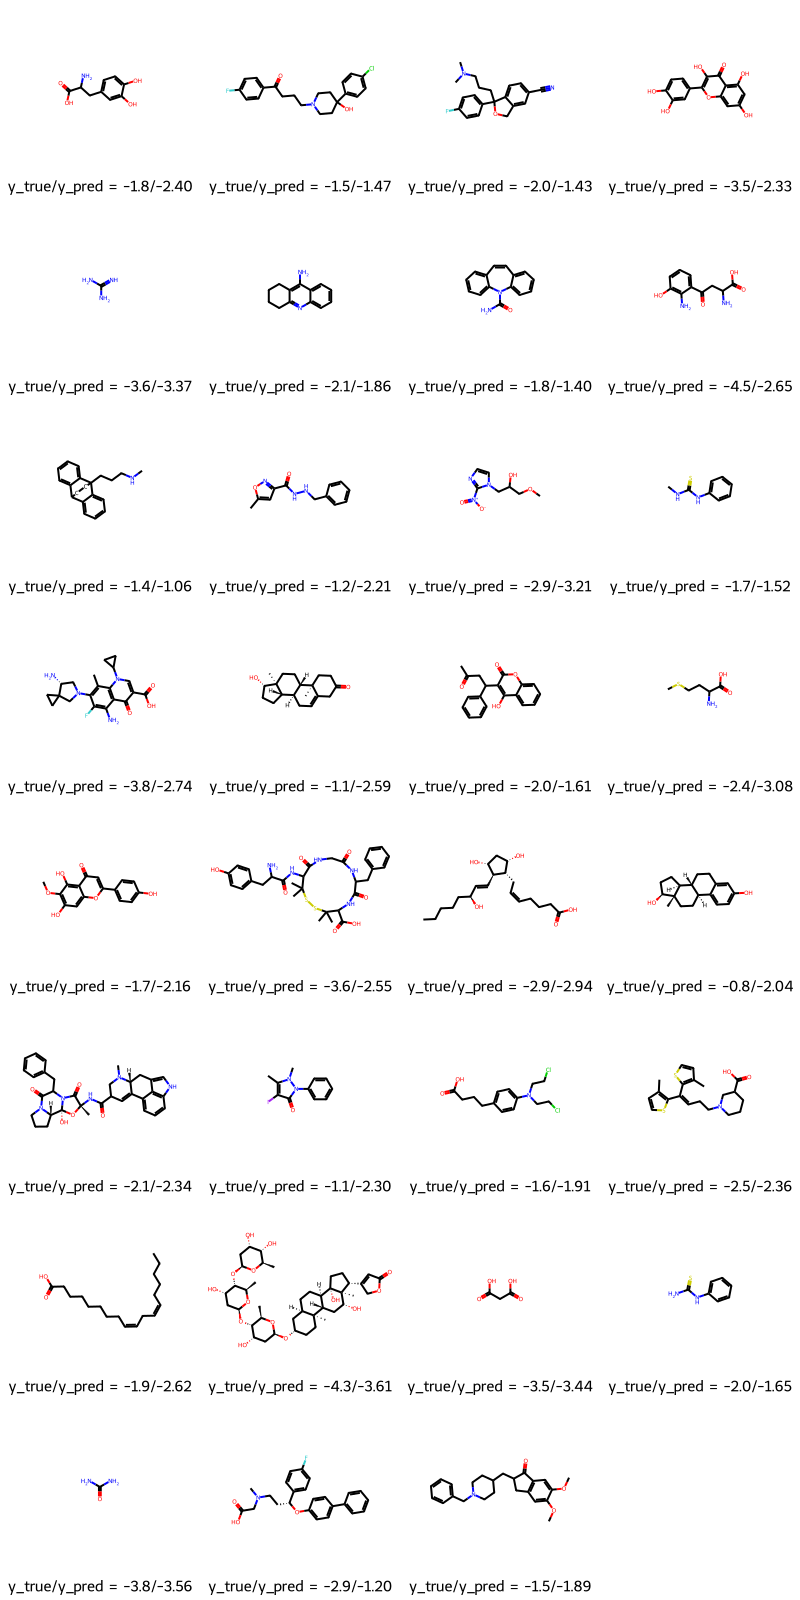

In [19]:
molecules = [molecule_from_smiles(total.smiles_standarized.values[index]) for index in valid_index]
y_true = [total.label.values[index] for index in valid_index]
y_pred = tf.squeeze(mpnn.predict(valid_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

In [20]:
valid_dataset = MPNNDataset(x_valid, y_valid)
test_loss, test_mae = mpnn.evaluate(valid_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

predictions = mpnn.predict(valid_dataset)
r2 = r2_score(y_valid, predictions)
print(f"R^2 Score: {r2}")

1/1 [==============================] - 0s 240ms/step - loss: 0.6346 - MAE: 0.6249
Test Loss: 0.6346043348312378
Test MAE: 0.6249377131462097
1/1 [==============================] - 0s 222ms/step
R^2 Score: 0.36994569331753535


1/1 [==============================] - 0s 257ms/step
Shape of y_test: (31,)
Shape of y_pred: (31,)
Mean Absolute Error (MAE): 0.6249377227598621
Mean Squared Error (MSE): 0.6346043346620445


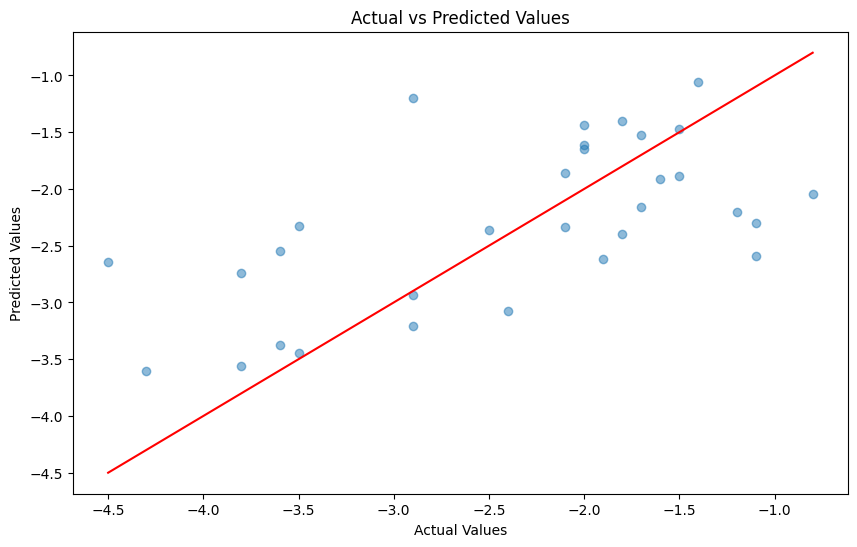

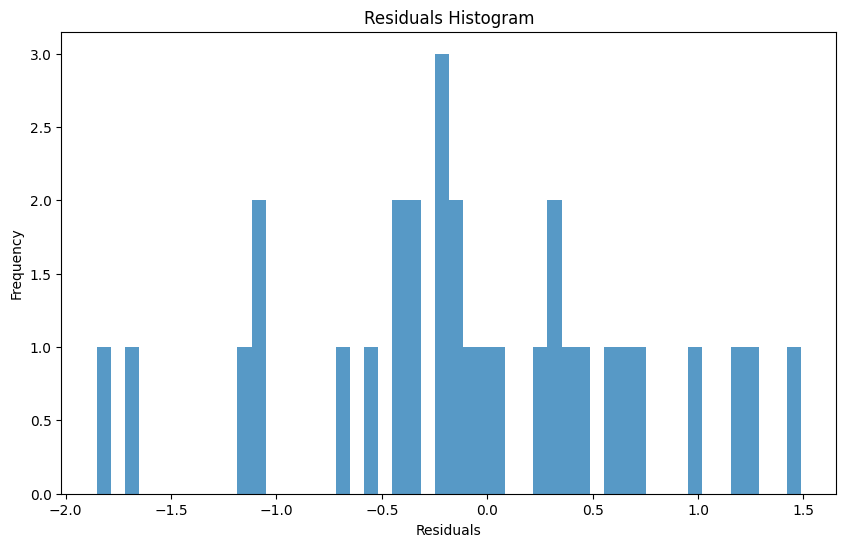

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load the test dataset and make predictions
test_dataset = MPNNDataset(x_valid, y_valid)
y_pred = mpnn.predict(valid_dataset)

# Ensure y_test and y_pred are numpy arrays
y_test = np.array(y_valid)
y_pred = np.array(y_pred).squeeze()  # Remove the extra dimension if it exists

# Check the shape of y_test and y_pred
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# Plot residuals (errors)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()


In [ ]:
# TEST 2:

In [22]:
# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(total.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(total.shape[0] * 0.8)]
x_train = graphs_from_smiles(total.iloc[train_index].smiles_standarized)
y_train = total.iloc[train_index].label

# Valid set: 20 % of data
valid_index = permuted_indices[int(total.shape[0] * 0.8) : ]
x_valid = graphs_from_smiles(total.iloc[valid_index].smiles_standarized)
y_valid = total.iloc[valid_index].label


In [23]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    verbose=2,
    callbacks=[early_stopping]
)


Epoch 1/40
4/4 - 2s - loss: 0.8169 - MAE: 0.7249 - val_loss: 0.8707 - val_MAE: 0.7672 - 2s/epoch - 575ms/step
Epoch 2/40
4/4 - 3s - loss: 0.8236 - MAE: 0.7099 - val_loss: 0.9288 - val_MAE: 0.8162 - 3s/epoch - 797ms/step
Epoch 3/40
4/4 - 4s - loss: 0.7262 - MAE: 0.6909 - val_loss: 0.9098 - val_MAE: 0.7625 - 4s/epoch - 913ms/step
Epoch 4/40
4/4 - 3s - loss: 0.7173 - MAE: 0.6652 - val_loss: 0.8059 - val_MAE: 0.7481 - 3s/epoch - 811ms/step
Epoch 5/40
4/4 - 2s - loss: 0.6748 - MAE: 0.6399 - val_loss: 0.7899 - val_MAE: 0.7252 - 2s/epoch - 441ms/step
Epoch 6/40
4/4 - 2s - loss: 0.6246 - MAE: 0.6223 - val_loss: 0.8573 - val_MAE: 0.7181 - 2s/epoch - 385ms/step
Epoch 7/40
4/4 - 2s - loss: 0.6259 - MAE: 0.6146 - val_loss: 0.7642 - val_MAE: 0.7069 - 2s/epoch - 418ms/step
Epoch 8/40
4/4 - 2s - loss: 0.5853 - MAE: 0.6042 - val_loss: 0.7531 - val_MAE: 0.6982 - 2s/epoch - 388ms/step
Epoch 9/40
4/4 - 2s - loss: 0.5481 - MAE: 0.5829 - val_loss: 0.8053 - val_MAE: 0.7179 - 2s/epoch - 383ms/step
Epoch 10/4

In [24]:
from sklearn.metrics import mean_squared_error, r2_score

train_predictions = mpnn.predict(train_dataset)
train_loss, train_mae = mpnn.evaluate(train_dataset)
print(f"Train MAE: {train_mae}")

r2_train = r2_score(y_train, train_predictions)
print(f"Training R-squared: {r2_train}")



4/4 [==============================] - 1s 143ms/step - loss: 0.2986 - MAE: 0.4000
Train MAE: 0.3999626338481903
Training R-squared: 0.7706451475136914


1/1 [==============================] - 0s 287ms/step


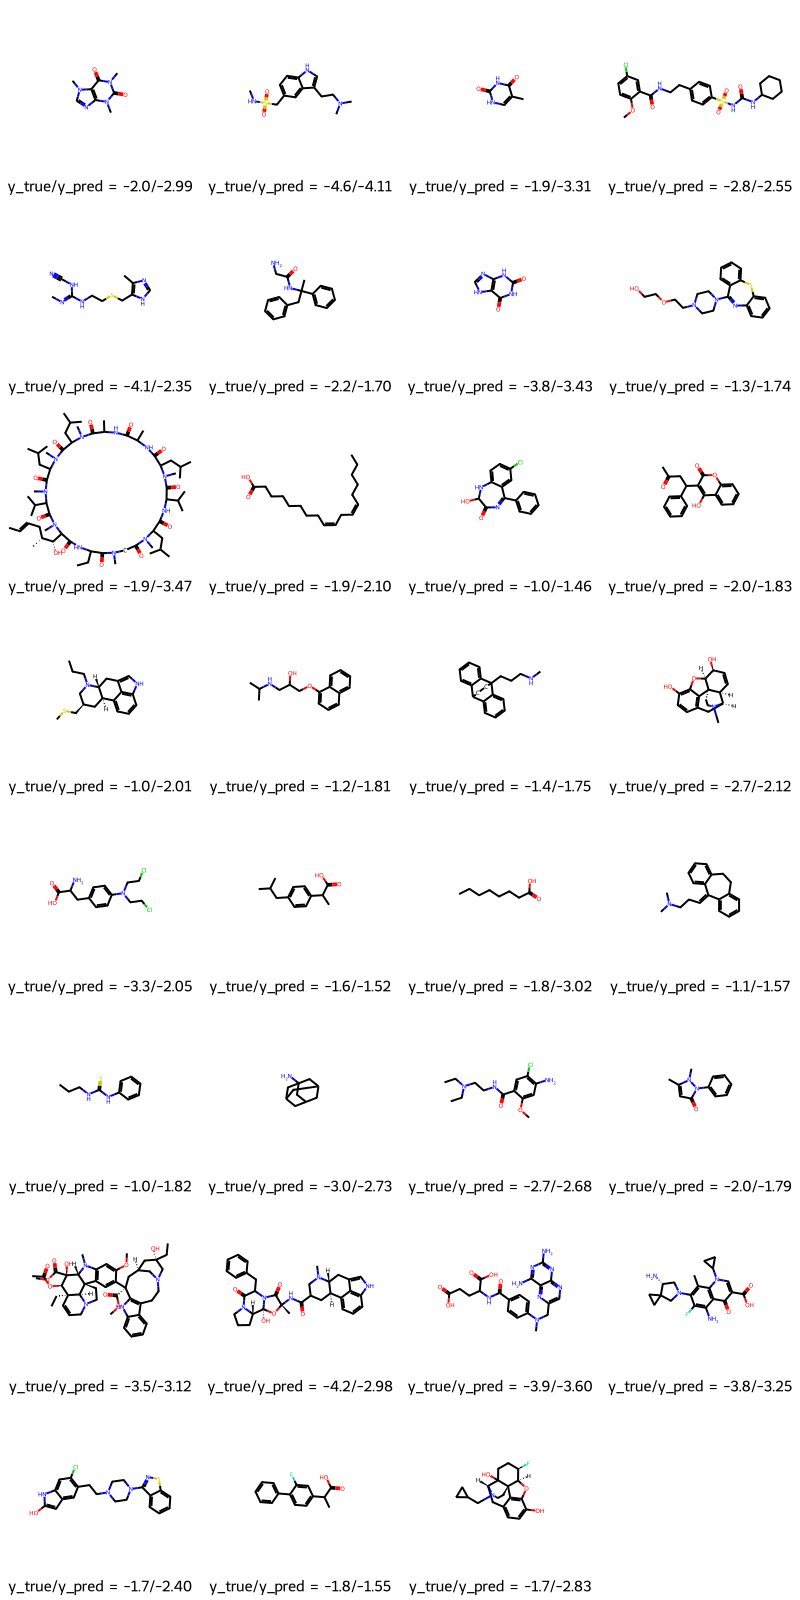

In [25]:
molecules = [molecule_from_smiles(total.smiles_standarized.values[index]) for index in valid_index]
y_true = [total.label.values[index] for index in valid_index]
y_pred = tf.squeeze(mpnn.predict(valid_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

In [26]:
valid_dataset = MPNNDataset(x_valid, y_valid)
test_loss, test_mae = mpnn.evaluate(valid_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")



1/1 [==============================] - 0s 334ms/step - loss: 0.6258 - MAE: 0.6454
Test Loss: 0.6258295774459839
Test MAE: 0.6453763842582703


In [27]:
pip install scikit-learn


In [28]:
predictions = mpnn.predict(valid_dataset)


1/1 [==============================] - 0s 458ms/step


In [29]:
from sklearn.metrics import r2_score

r2 = r2_score(y_valid, predictions)
print(f"R^2 Score: {r2}")

R^2 Score: 0.43956781795531463


1/1 [==============================] - 1s 617ms/step
Shape of y_test: (31,)
Shape of y_pred: (31,)
Mean Absolute Error (MAE): 0.6453763969482914
Mean Squared Error (MSE): 0.6258295440576833


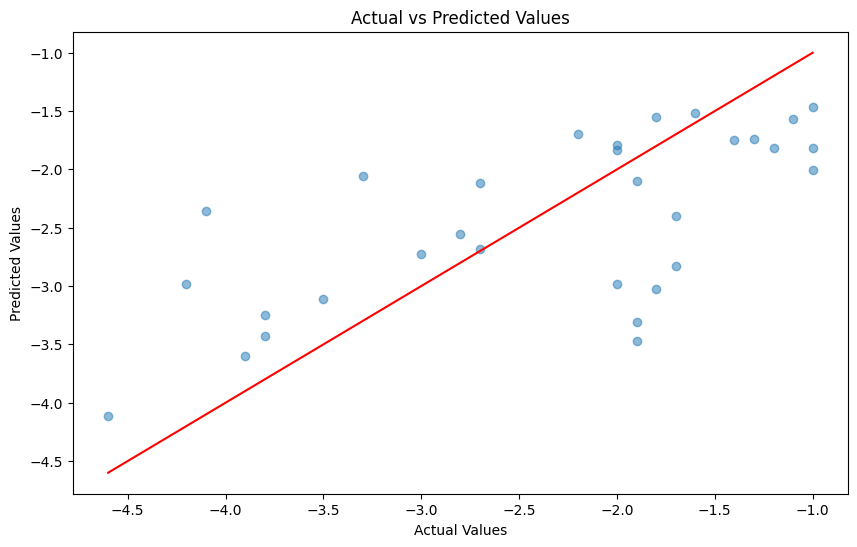

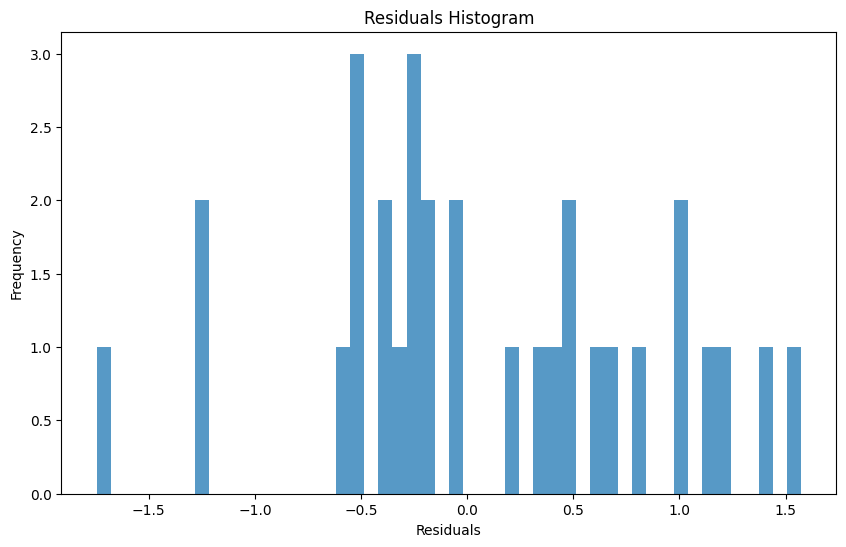

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load the test dataset and make predictions
test_dataset = MPNNDataset(x_valid, y_valid)
y_pred = mpnn.predict(valid_dataset)

# Ensure y_test and y_pred are numpy arrays
y_test = np.array(y_valid)
y_pred = np.array(y_pred).squeeze()  # Remove the extra dimension if it exists

# Check the shape of y_test and y_pred
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# Plot residuals (errors)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()


In [ ]:
# TEST 3:

In [31]:
# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(total.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(total.shape[0] * 0.8)]
x_train = graphs_from_smiles(total.iloc[train_index].smiles_standarized)
y_train = total.iloc[train_index].label

# Valid set: 20 % of data
valid_index = permuted_indices[int(total.shape[0] * 0.8) : ]
x_valid = graphs_from_smiles(total.iloc[valid_index].smiles_standarized)
y_valid = total.iloc[valid_index].label


In [32]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    verbose=2,
    callbacks=[early_stopping]
)


Epoch 1/40
4/4 - 2s - loss: 0.5303 - MAE: 0.5612 - val_loss: 0.6528 - val_MAE: 0.7040 - 2s/epoch - 433ms/step
Epoch 2/40
4/4 - 3s - loss: 0.6103 - MAE: 0.6338 - val_loss: 0.6729 - val_MAE: 0.6300 - 3s/epoch - 794ms/step
Epoch 3/40
4/4 - 3s - loss: 0.4634 - MAE: 0.5350 - val_loss: 0.5138 - val_MAE: 0.5482 - 3s/epoch - 807ms/step
Epoch 4/40
4/4 - 3s - loss: 0.4356 - MAE: 0.5092 - val_loss: 0.8105 - val_MAE: 0.7017 - 3s/epoch - 856ms/step
Epoch 5/40
4/4 - 2s - loss: 0.3981 - MAE: 0.5240 - val_loss: 0.6065 - val_MAE: 0.6101 - 2s/epoch - 472ms/step
Epoch 6/40
4/4 - 2s - loss: 0.3760 - MAE: 0.4791 - val_loss: 0.6174 - val_MAE: 0.6053 - 2s/epoch - 425ms/step
Epoch 7/40
4/4 - 2s - loss: 0.3401 - MAE: 0.4720 - val_loss: 0.6534 - val_MAE: 0.6205 - 2s/epoch - 412ms/step
Epoch 8/40
4/4 - 2s - loss: 0.3293 - MAE: 0.4563 - val_loss: 0.7311 - val_MAE: 0.6651 - 2s/epoch - 594ms/step


In [33]:
from sklearn.metrics import mean_squared_error, r2_score

train_predictions = mpnn.predict(train_dataset)
train_loss, train_mae = mpnn.evaluate(train_dataset)
print(f"Train MAE: {train_mae}")

r2_train = r2_score(y_train, train_predictions)
print(f"Training R-squared: {r2_train}")



4/4 [==============================] - 1s 116ms/step - loss: 0.4556 - MAE: 0.5201
Train MAE: 0.5201322436332703
Training R-squared: 0.592567986988253


1/1 [==============================] - 0s 264ms/step


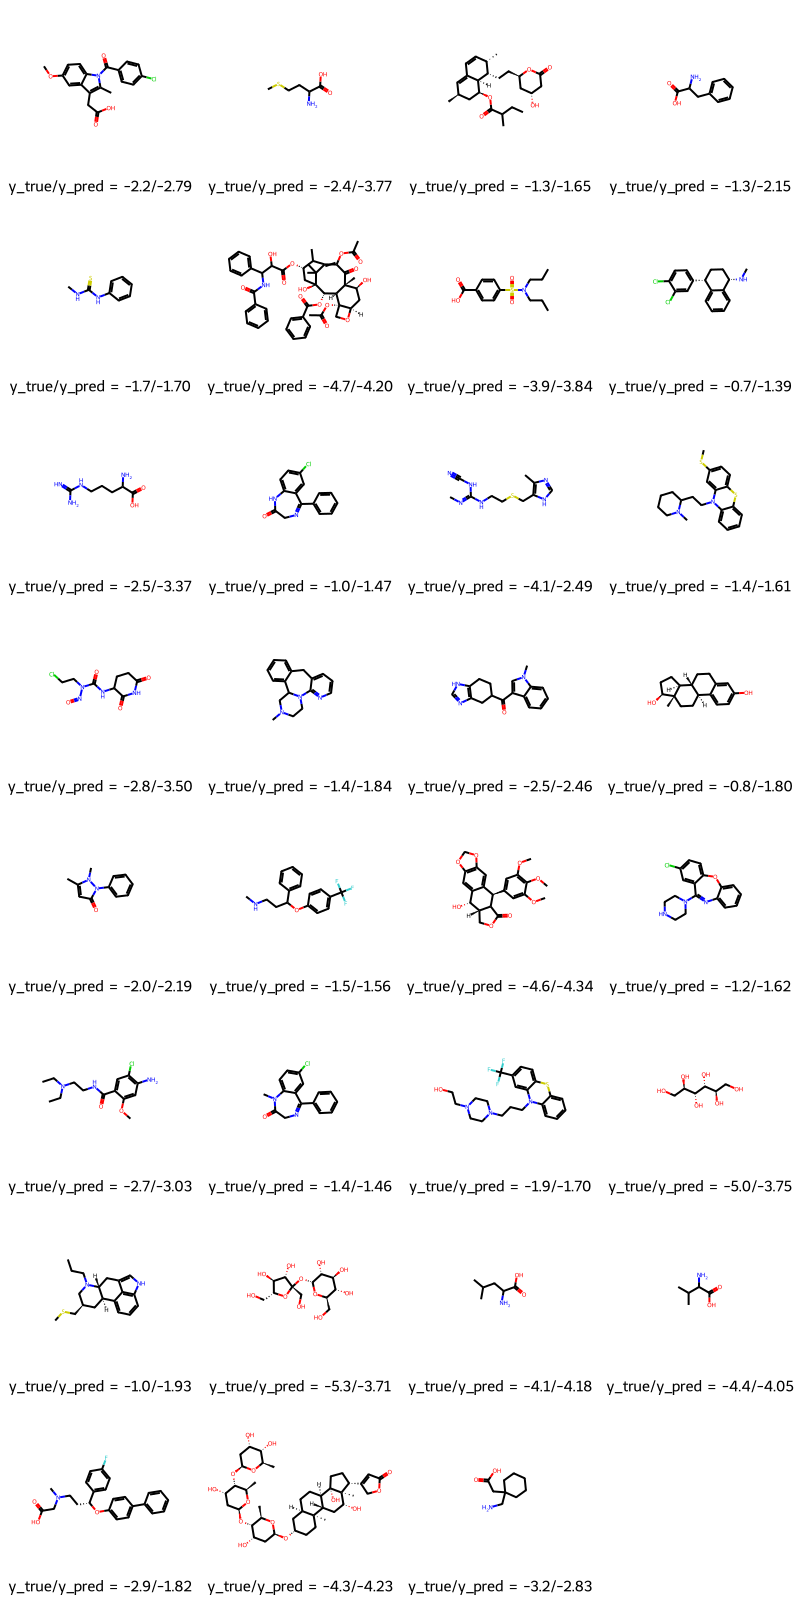

In [34]:
molecules = [molecule_from_smiles(total.smiles_standarized.values[index]) for index in valid_index]
y_true = [total.label.values[index] for index in valid_index]
y_pred = tf.squeeze(mpnn.predict(valid_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

In [35]:
valid_dataset = MPNNDataset(x_valid, y_valid)
test_loss, test_mae = mpnn.evaluate(valid_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

predictions = mpnn.predict(valid_dataset)
r2 = r2_score(y_valid, predictions)
print(f"R^2 Score: {r2}")

1/1 [==============================] - 0s 456ms/step - loss: 0.5138 - MAE: 0.5482
Test Loss: 0.5137875080108643
Test MAE: 0.5482165813446045
1/1 [==============================] - 0s 304ms/step
R^2 Score: 0.7300202188773806


1/1 [==============================] - 0s 267ms/step
Shape of y_test: (31,)
Shape of y_pred: (31,)
Mean Absolute Error (MAE): 0.5482165398136262
Mean Squared Error (MSE): 0.5137875368452562


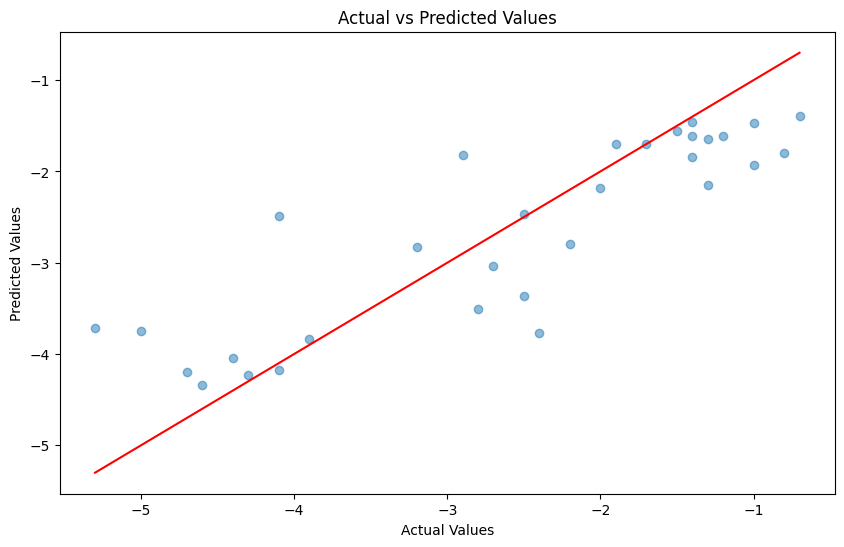

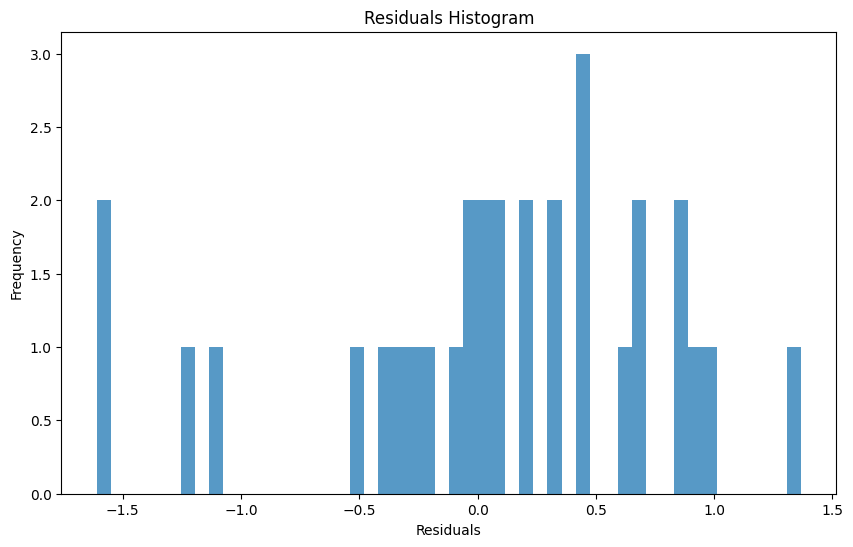

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load the test dataset and make predictions
test_dataset = MPNNDataset(x_valid, y_valid)
y_pred = mpnn.predict(valid_dataset)

# Ensure y_test and y_pred are numpy arrays
y_test = np.array(y_valid)
y_pred = np.array(y_pred).squeeze()  # Remove the extra dimension if it exists

# Check the shape of y_test and y_pred
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# Plot residuals (errors)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()


In [ ]:
#TEST 4:

In [37]:
# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(total.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(total.shape[0] * 0.8)]
x_train = graphs_from_smiles(total.iloc[train_index].smiles_standarized)
y_train = total.iloc[train_index].label

# Valid set: 20 % of data
valid_index = permuted_indices[int(total.shape[0] * 0.8) : ]
x_valid = graphs_from_smiles(total.iloc[valid_index].smiles_standarized)
y_valid = total.iloc[valid_index].label


In [38]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    verbose=2,
    callbacks=[early_stopping]
)


Epoch 1/40
4/4 - 2s - loss: 0.5442 - MAE: 0.5926 - val_loss: 0.2543 - val_MAE: 0.4113 - 2s/epoch - 541ms/step
Epoch 2/40
4/4 - 2s - loss: 0.5160 - MAE: 0.5427 - val_loss: 0.2929 - val_MAE: 0.4231 - 2s/epoch - 401ms/step
Epoch 3/40
4/4 - 2s - loss: 0.4422 - MAE: 0.5101 - val_loss: 0.3623 - val_MAE: 0.4876 - 2s/epoch - 456ms/step
Epoch 4/40
4/4 - 2s - loss: 0.3978 - MAE: 0.4920 - val_loss: 0.2962 - val_MAE: 0.4063 - 2s/epoch - 624ms/step
Epoch 5/40
4/4 - 3s - loss: 0.3747 - MAE: 0.4819 - val_loss: 0.3142 - val_MAE: 0.4252 - 3s/epoch - 660ms/step
Epoch 6/40
4/4 - 2s - loss: 0.3357 - MAE: 0.4472 - val_loss: 0.3054 - val_MAE: 0.4351 - 2s/epoch - 407ms/step


In [39]:
from sklearn.metrics import mean_squared_error, r2_score

train_predictions = mpnn.predict(train_dataset)
train_loss, train_mae = mpnn.evaluate(train_dataset)
print(f"Train MAE: {train_mae}")

r2_train = r2_score(y_train, train_predictions)
print(f"Training R-squared: {r2_train}")



4/4 [==============================] - 2s 253ms/step - loss: 0.5017 - MAE: 0.5674
Train MAE: 0.5673905611038208
Training R-squared: 0.6121047610289767


1/1 [==============================] - 0s 194ms/step


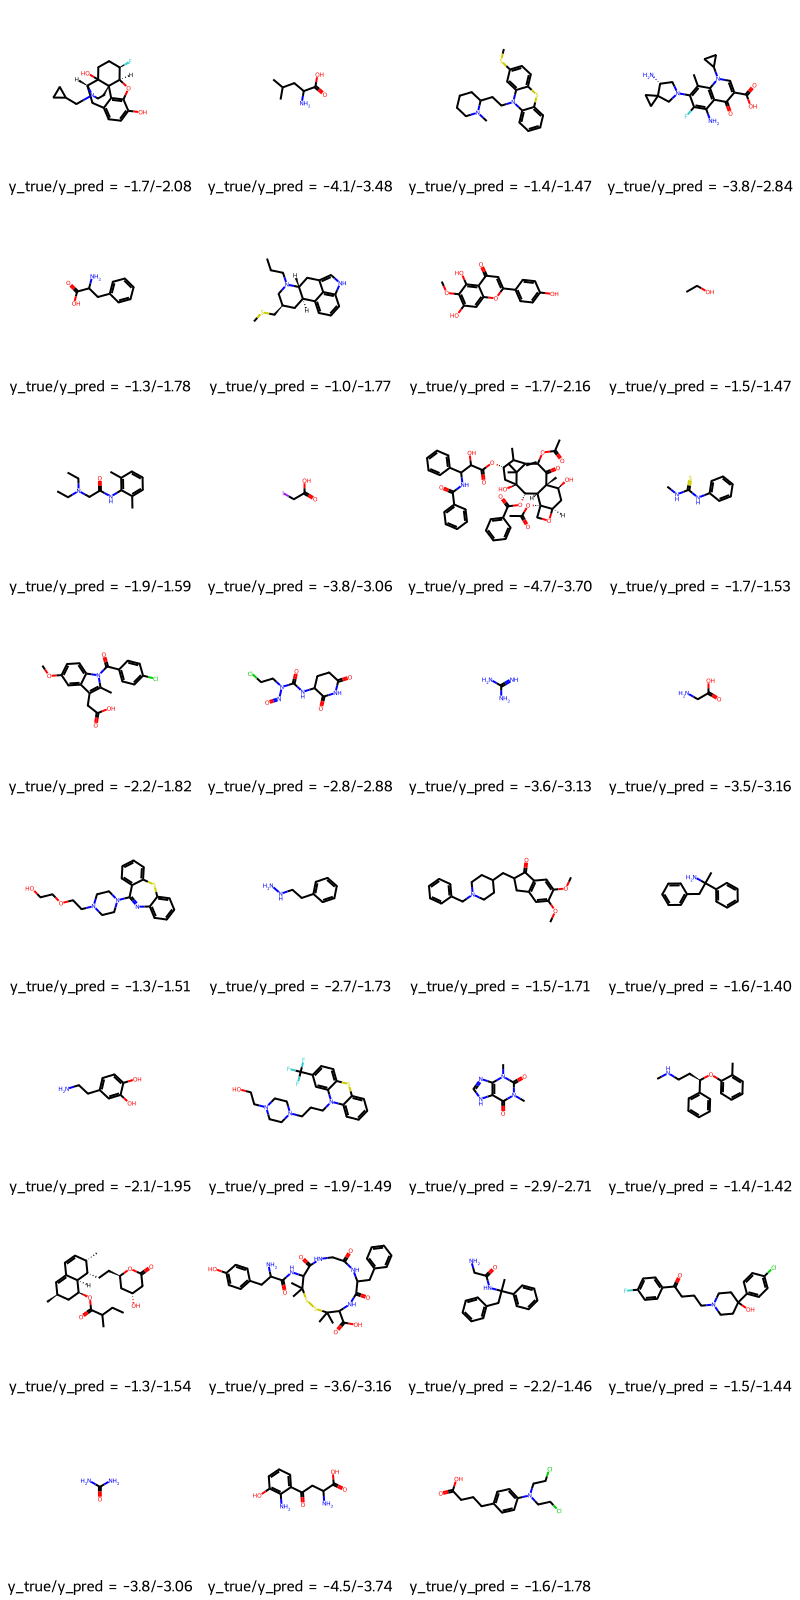

In [40]:
molecules = [molecule_from_smiles(total.smiles_standarized.values[index]) for index in valid_index]
y_true = [total.label.values[index] for index in valid_index]
y_pred = tf.squeeze(mpnn.predict(valid_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

In [41]:
valid_dataset = MPNNDataset(x_valid, y_valid)
test_loss, test_mae = mpnn.evaluate(valid_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

predictions = mpnn.predict(valid_dataset)
r2 = r2_score(y_valid, predictions)
print(f"R^2 Score: {r2}")

1/1 [==============================] - 0s 224ms/step - loss: 0.2543 - MAE: 0.4113
Test Loss: 0.25434303283691406
Test MAE: 0.41134268045425415
1/1 [==============================] - 0s 206ms/step
R^2 Score: 0.7839749303910667


1/1 [==============================] - 0s 214ms/step
Shape of y_test: (31,)
Shape of y_pred: (31,)
Mean Absolute Error (MAE): 0.41134272775342395
Mean Squared Error (MSE): 0.25434310640970204


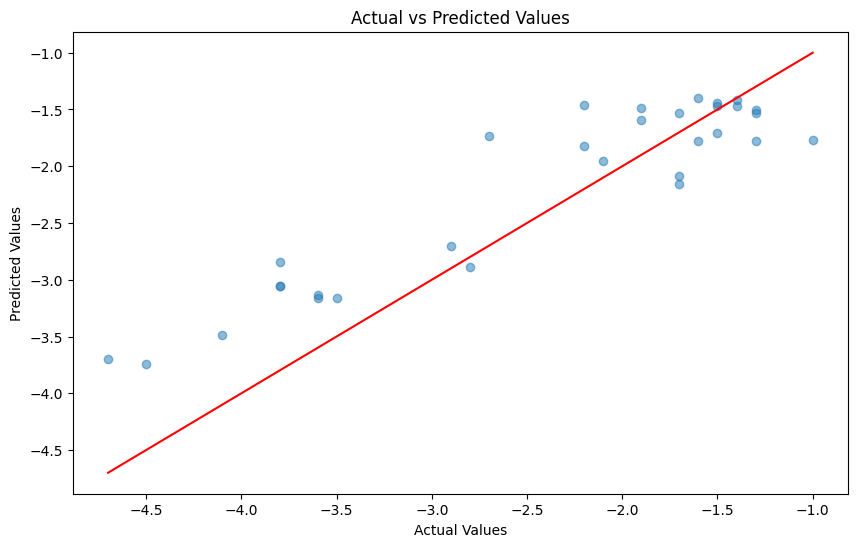

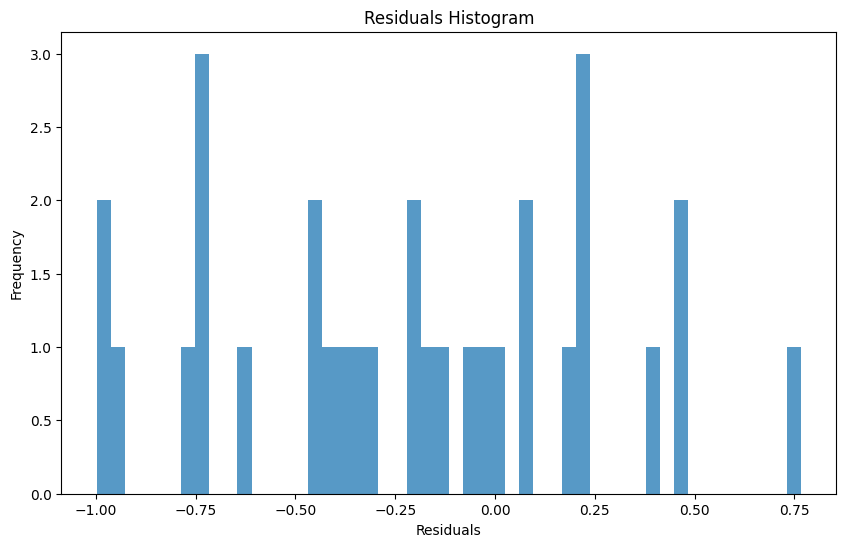

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load the test dataset and make predictions
test_dataset = MPNNDataset(x_valid, y_valid)
y_pred = mpnn.predict(valid_dataset)

# Ensure y_test and y_pred are numpy arrays
y_test = np.array(y_valid)
y_pred = np.array(y_pred).squeeze()  # Remove the extra dimension if it exists

# Check the shape of y_test and y_pred
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# Plot residuals (errors)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()


In [ ]:
#TEST 5:

In [43]:
# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(total.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(total.shape[0] * 0.8)]
x_train = graphs_from_smiles(total.iloc[train_index].smiles_standarized)
y_train = total.iloc[train_index].label

# Valid set: 20 % of data
valid_index = permuted_indices[int(total.shape[0] * 0.8) : ]
x_valid = graphs_from_smiles(total.iloc[valid_index].smiles_standarized)
y_valid = total.iloc[valid_index].label


In [44]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    verbose=2,
    callbacks=[early_stopping]
)


Epoch 1/40
4/4 - 2s - loss: 0.4092 - MAE: 0.4932 - val_loss: 0.5282 - val_MAE: 0.5952 - 2s/epoch - 485ms/step
Epoch 2/40
4/4 - 3s - loss: 0.5379 - MAE: 0.5569 - val_loss: 0.7035 - val_MAE: 0.6928 - 3s/epoch - 650ms/step
Epoch 3/40
4/4 - 2s - loss: 0.3968 - MAE: 0.4986 - val_loss: 0.5643 - val_MAE: 0.6087 - 2s/epoch - 617ms/step
Epoch 4/40
4/4 - 2s - loss: 0.3968 - MAE: 0.4862 - val_loss: 0.7381 - val_MAE: 0.7334 - 2s/epoch - 415ms/step
Epoch 5/40
4/4 - 2s - loss: 0.3503 - MAE: 0.4603 - val_loss: 0.6026 - val_MAE: 0.5999 - 2s/epoch - 440ms/step
Epoch 6/40
4/4 - 2s - loss: 0.3742 - MAE: 0.4644 - val_loss: 0.5892 - val_MAE: 0.6563 - 2s/epoch - 584ms/step


In [45]:
from sklearn.metrics import mean_squared_error, r2_score

train_predictions = mpnn.predict(train_dataset)
train_loss, train_mae = mpnn.evaluate(train_dataset)
print(f"Train MAE: {train_mae}")

r2_train = r2_score(y_train, train_predictions)
print(f"Training R-squared: {r2_train}")



4/4 [==============================] - 1s 206ms/step - loss: 0.5215 - MAE: 0.5500
Train MAE: 0.5499542951583862
Training R-squared: 0.5990919068034906


1/1 [==============================] - 0s 247ms/step


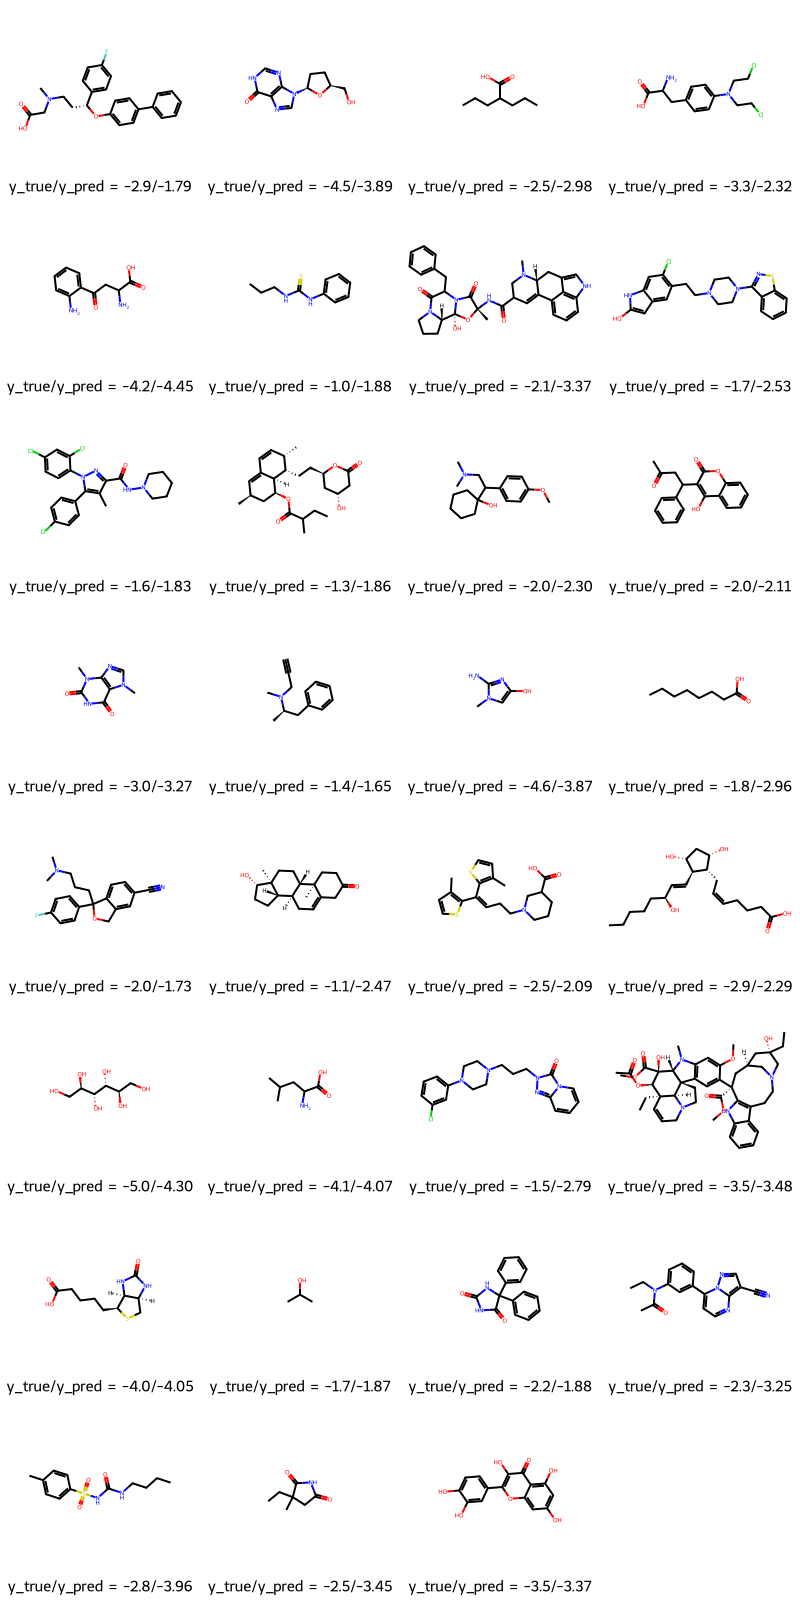

In [47]:
molecules = [molecule_from_smiles(total.smiles_standarized.values[index]) for index in valid_index]
y_true = [total.label.values[index] for index in valid_index]
y_pred = tf.squeeze(mpnn.predict(valid_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

In [48]:
valid_dataset = MPNNDataset(x_valid, y_valid)
test_loss, test_mae = mpnn.evaluate(valid_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

predictions = mpnn.predict(valid_dataset)
r2 = r2_score(y_valid, predictions)
print(f"R^2 Score: {r2}")

1/1 [==============================] - 0s 296ms/step - loss: 0.5282 - MAE: 0.5952
Test Loss: 0.5281956195831299
Test MAE: 0.5951535105705261
1/1 [==============================] - 0s 260ms/step
R^2 Score: 0.5529128444788813


1/1 [==============================] - 0s 344ms/step
Shape of y_test: (31,)
Shape of y_pred: (31,)
Mean Absolute Error (MAE): 0.5951534971114127
Mean Squared Error (MSE): 0.5281955579077491


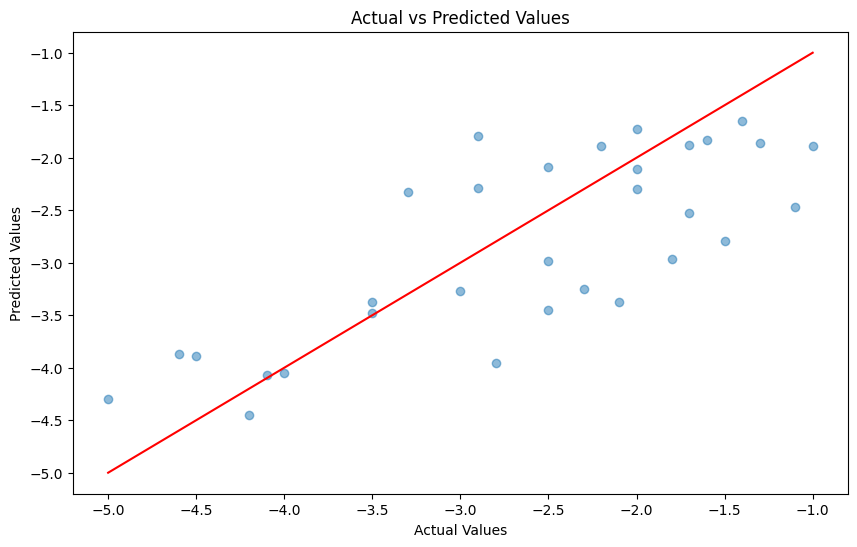

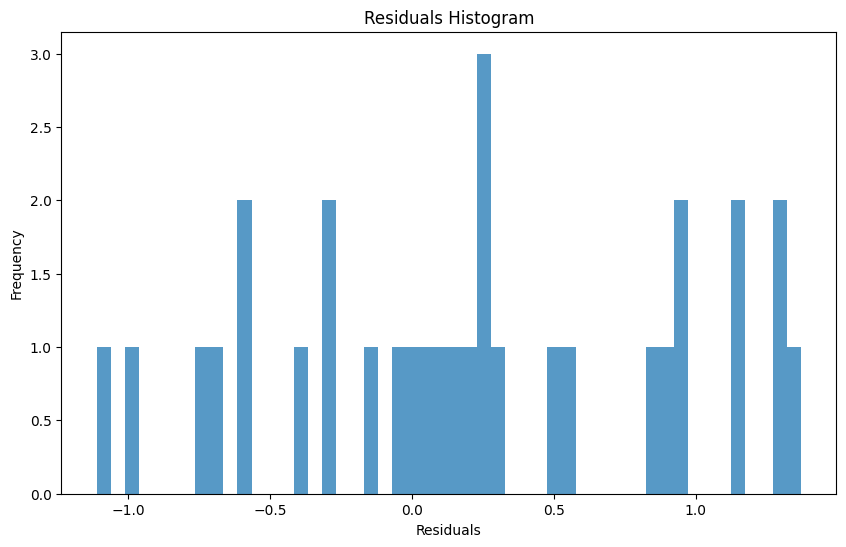

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load the test dataset and make predictions
test_dataset = MPNNDataset(x_valid, y_valid)
y_pred = mpnn.predict(valid_dataset)

# Ensure y_test and y_pred are numpy arrays
y_test = np.array(y_valid)
y_pred = np.array(y_pred).squeeze()  # Remove the extra dimension if it exists

# Check the shape of y_test and y_pred
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# Plot residuals (errors)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()


In [54]:
l=[0.36994569331753535,  0.43956781795531463,  0.7300202188773806, 0.7839749303910667, 0.5529128444788813]
sum=0
for i in l:
  sum+=i
print(sum/5)

0.5752843010040356


In [55]:
import numpy as np
import scipy.stats as stats

mae_values = np.array([0.6249377131462097,  0.6453763842582703,  0.5482165813446045, 0.41134268045425415, 0.5951535105705261])
r2_values = np.array([0.36994569331753535,  0.43956781795531463,  0.7300202188773806, 0.7839749303910667, 0.5529128444788813])

def calculate_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    t_score = stats.t.ppf((1 + confidence) / 2.0, n - 1)
    margin_of_error = t_score * std_err
    return mean - margin_of_error, mean + margin_of_error


mae_conf_interval = calculate_confidence_interval(mae_values)
print(f"95% Confidence Interval for MAE: {mae_conf_interval}")


r2_conf_interval = calculate_confidence_interval(r2_values)
print(f"95% Confidence Interval for R-squared: {r2_conf_interval}")


95% Confidence Interval for MAE: (0.44910021029428665, 0.6809105376152591)
95% Confidence Interval for R-squared: (0.35266743940018586, 0.7979011626078854)
